### 1. 데이터 로드

In [1]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split

In [2]:
df = fdr.DataReader('ETH/KRW', '2017-11-11', '2023-02-07') # 빗썸기준
df.tail() # 시가, 고가, 저가, 종가, 조정 종가, 거래량

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-02,2006200.625,2084810.250,2003982.250,2013381.750,2013381.750,12936288829592
2023-02-03,2012969.000,2078767.500,2007286.500,2077352.750,2077352.750,10194335288017
2023-02-04,2077011.750,2109007.750,2056692.875,2080239.875,2080239.875,7291565039205
2023-02-05,2080373.625,2086118.500,2017014.500,2036055.625,2036055.625,8643504898765
2023-02-06,2036054.875,2085601.625,2032647.000,2038984.625,2038984.625,8729798977234


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1914 entries, 2017-11-11 to 2023-02-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1914 non-null   float64
 1   High       1914 non-null   float64
 2   Low        1914 non-null   float64
 3   Close      1914 non-null   float64
 4   Adj Close  1914 non-null   float64
 5   Volume     1914 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 104.7 KB


### 2. 데이터 전처리

In [4]:
# 가격을 0~1사이로 변환. 시간 소요 절감 가능.
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominater = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominater + 1e-7) # 0으로 나누기 에러 방지 위해 1e-7 더함

In [5]:
# Open	High	Low	Close	Adj Close	Volume
df_x = df[['Open', 'High', 'Low', 'Volume']]
df_x = MinMaxScaler(df_x)
df_y = df[['Close']] # 타겟 데이터. 종가 예측.
df_y = MinMaxScaler(df_y)

In [6]:
print(df_x.head())
print(df_y.head())

                Open      High       Low    Volume
Date                                              
2017-11-11  0.042057  0.045877  0.043986  0.002777
2017-11-12  0.045231  0.045818  0.044052  0.011853
2017-11-13  0.043640  0.047700  0.045802  0.005128
2017-11-14  0.045617  0.049798  0.047791  0.005415
2017-11-15  0.049578  0.049619  0.049529  0.001260
               Close
Date                
2017-11-11  0.045205
2017-11-12  0.043790
2017-11-13  0.045583
2017-11-14  0.049486
2017-11-15  0.048073


In [7]:
df_x.describe()

,Open,High,Low,Volume
count,1914.000000,1914.000000,1914.000000,1914.000000
mean,0.221358,0.228164,0.221689,0.152585
std,0.247294,0.254114,0.248226,0.130698
min,0.000000,0.000000,0.000000,0.000000
25%,0.027574,0.028392,0.027700,0.046661
50%,0.086837,0.089579,0.084995,0.126207
75%,0.361787,0.373063,0.365029,0.223616
max,1.000000,1.000000,1.000000,1.000000


In [8]:
# 넘파이 배열로 변경
X = np.array(df_x)
y = np.array(df_y)
# y = y.reshape(-1)
print(X.shape, y.shape)

(1914, 4) (1914, 1)


### 2-1. 10일 동안의 OHLVC 데이터로 다음날 종가 예측
- O(open), H(high), L(low), V(Volume), C(close)

In [9]:
window_size = 10

data_X, data_y = [], []

for i in range(len(y) - window_size):
    _X = X[i: i + window_size] # 다음 날 종가(i+window_size)는 포함 X
    _y = y[i + window_size] # 다음날 종가
    data_X.append(_X)
    data_y.append(_y)
print(_X, '->', _y)

[[0.33091525 0.33251827 0.3346751  0.09814957]
 [0.3292357  0.32986274 0.33498677 0.06806618]
 [0.3237151  0.34045839 0.33579521 0.10692226]
 [0.3396319  0.33892749 0.33127727 0.11201116]
 [0.32308294 0.32944408 0.33469727 0.07837039]
 [0.32741442 0.33592066 0.33535391 0.09738735]
 [0.33635208 0.34935789 0.34933485 0.12916111]
 [0.33754353 0.34829605 0.349939   0.10026601]
 [0.34881714 0.35360989 0.35897238 0.06967621]
 [0.34940894 0.34958778 0.35171765 0.08392314]] -> [0.34197364]


In [10]:
# 10일간의 OHLVC 데이터
print(data_X[0])
print(data_y[0])

[[0.04205678 0.04587698 0.04398627 0.00277695]
 [0.04523142 0.04581794 0.044052   0.01185257]
 [0.04363986 0.0477     0.04580217 0.00512787]
 [0.04561721 0.04979792 0.04779052 0.00541457]
 [0.04957796 0.04961933 0.04952856 0.00125962]
 [0.04811531 0.0476753  0.0477699  0.00204975]
 [0.04692941 0.04739893 0.04862181 0.        ]
 [0.04708829 0.05018149 0.04843482 0.00032152]
 [0.05005622 0.05434566 0.05184373 0.00644027]
 [0.05129698 0.05466775 0.05363472 0.00215758]]
[0.05239914]


### 2-2. data split

In [11]:
train_size = int(len(data_y)*0.7)
X_train = np.array(data_X[0:train_size])
y_train = np.array(data_y[0:train_size])

test_size = len(data_y) - train_size
X_test = np.array(data_X[train_size: len(data_X)])
y_test = np.array(data_y[train_size: len(data_y)])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1332, 10, 4) (1332, 1)
(572, 10, 4) (572, 1)


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3) # 시계열 데이터 이기 대문에 shuffle=False
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

### 3. 모델 학습

In [12]:
## 객체 생성
model = Sequential(name = 'eth')
model.add(LSTM(20, input_shape=(10,4), activation='relu')) # 10일치의 데이터
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

Model: "eth"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                2000      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 2,021
Trainable params: 2,021
Non-trainable params: 0
_________________________________________________________________


In [13]:
## 컴파일
model.compile(loss='mse', optimizer='adam', metrics='acc')

In [14]:
print(X_train.shape, y_train.shape)

(1332, 10, 4) (1332, 1)


In [15]:
model_path = './model/eth/{epoch:2d}-{val_loss:.4f}.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True)
earlystop = keras.callbacks.EarlyStopping(patience=10)
# history = model.fit(X_train, y_train, epochs=70, batch_size=30)
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/200
34/34 [==============================] - ETA: 0s - loss: 9.9900e-04 - acc: 9.3897e-04
Epoch 1: val_loss improved from inf to 0.02387, saving model to ./model/eth\ 1-0.0239.hdf5
34/34 [==============================] - 2s 15ms/step - loss: 9.9900e-04 - acc: 9.3897e-04 - val_loss: 0.0239 - val_acc: 0.0000e+00
Epoch 2/200
23/34 [===================>..........] - ETA: 0s - loss: 3.8147e-04 - acc: 0.0014    
Epoch 2: val_loss improved from 0.02387 to 0.00298, saving model to ./model/eth\ 2-0.0030.hdf5
34/34 [==============================] - 0s 6ms/step - loss: 3.3754e-04 - acc: 9.3897e-04 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 3/200
32/34 [===========================>..] - ETA: 0s - loss: 2.9189e-04 - acc: 9.7656e-04
Epoch 3: val_loss improved from 0.00298 to 0.00203, saving model to ./model/eth\ 3-0.0020.hdf5
34/34 [==============================] - 0s 5ms/step - loss: 2.8960e-04 - acc: 9.3897e-04 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 4/200
31/34 [============

18/18 [==============================] - 0s 2ms/step


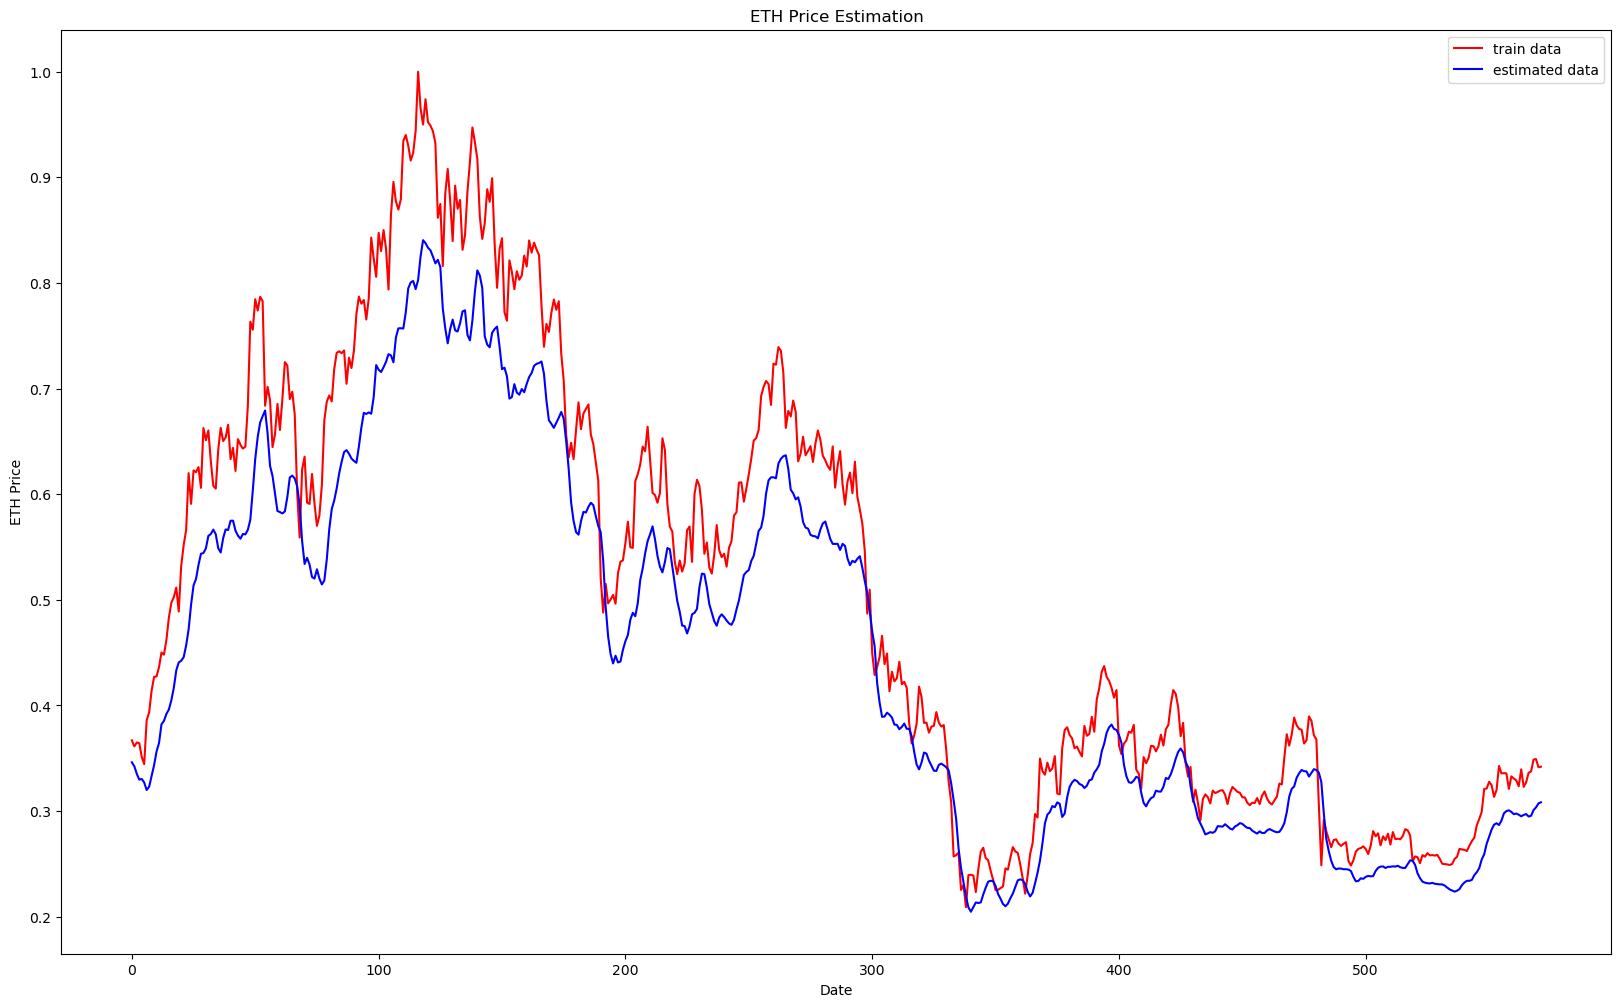

In [16]:
y_pred = model.predict(X_test)
plt.figure(figsize=(20,12))
plt.plot(y_test, color='red', label='train data')
plt.plot(y_pred, color='blue', label='estimated data')
plt.title('ETH Price Estimation')
plt.xlabel('Date')
plt.ylabel('ETH Price')
plt.legend()
plt.show()

In [17]:
last_estimated_price = (df.Close[-1] * y_pred[-1]) / df_y.Close[-1]
last_real_price = df.Close[-1]
a = last_estimated_price - last_real_price
print("2023-02-06 예상 ETH 가격 :", last_estimated_price, 'KRW')
print("2023-02-06 실제 ETH 가격 :", last_real_price, 'KRW')
print("차이 : ", a)

2023-02-06 예상 ETH 가격 : [1838087.6] KRW
2023-02-06 실제 ETH 가격 : 2038984.625 KRW
차이 :  [-200897.]


#### 차이가 있어 보이니까 특성들을 추가해보기로 함

In [18]:
# 미국 3대 지수 추가. DJI(다우존스), IXIC(나스닥), US500(S&P 500)
df_DJI = fdr.DataReader('DJI', '2017-11-11', '2023-02-07')
df_DJI.rename(columns={'Close':'DJI'}, inplace=True)
df_DJI = df_DJI.DJI

df_IXIC = fdr.DataReader('IXIC', '2017-11-11', '2023-02-07')
df_IXIC.rename(columns={'Close':'IXIC'}, inplace=True)
df_IXIC = df_IXIC.IXIC

df_US500 = fdr.DataReader('US500', '2017-11-11', '2023-02-07')
df_US500.rename(columns={'Close':'US500'}, inplace=True)
df_US500 = df_US500.US500


In [19]:
# 총 데이터 개수가 1316개임. 주말 데이터가 없다!!
print(len(df_DJI), len(df_IXIC), len(df_US500))

1316 1316 1316


In [20]:
df_dns = pd.merge(df, df_DJI, how='outer', on='Date')
df_dns = pd.merge(df_dns, df_IXIC, how='outer', on='Date')
df_dns = pd.merge(df_dns, df_US500, how='outer', on='Date')

In [21]:
df_dns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1914 entries, 2017-11-11 to 2023-02-06
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1914 non-null   float64
 1   High       1914 non-null   float64
 2   Low        1914 non-null   float64
 3   Close      1914 non-null   float64
 4   Adj Close  1914 non-null   float64
 5   Volume     1914 non-null   int64  
 6   DJI        1316 non-null   float64
 7   IXIC       1316 non-null   float64
 8   US500      1316 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 149.5 KB


In [22]:
# 주말 데이터가 없으므로(널값) 이전 데이터로 먼저 채워주고, 없으면 뒤에꺼로 채워주기
df_dns.fillna(method='ffill', inplace=True)
df_dns.fillna(method='bfill', inplace=True)

In [23]:
df_dns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1914 entries, 2017-11-11 to 2023-02-06
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1914 non-null   float64
 1   High       1914 non-null   float64
 2   Low        1914 non-null   float64
 3   Close      1914 non-null   float64
 4   Adj Close  1914 non-null   float64
 5   Volume     1914 non-null   int64  
 6   DJI        1914 non-null   float64
 7   IXIC       1914 non-null   float64
 8   US500      1914 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 149.5 KB


#### 데이터 스케일링부터 다시

In [24]:
df_x = df_dns[['Open', 'High', 'Low', 'Volume', 'DJI', 'IXIC', 'US500']]
df_x = MinMaxScaler(df_x)
df_y = df_dns[['Close']] # 타겟 데이터. 종가 예측.
df_y = MinMaxScaler(df_y)

In [25]:
# 넘파이 배열로 변경
X = np.array(df_x)
y = np.array(df_y)
print(X.shape, y.shape)

(1914, 7) (1914, 1)


In [26]:
window_size = 10

data_X, data_y = [], []

for i in range(len(y) - window_size):
    _X = X[i: i + window_size] # 다음 날 종가(i+window_size)는 포함 X
    _y = y[i + window_size] # 다음날 종가
    data_X.append(_X)
    data_y.append(_y)
print(_X, '->', _y)

[[0.33091525 0.33251827 0.3346751  0.09814957 0.84503439 0.55033491
  0.71631318]
 [0.3292357  0.32986274 0.33498677 0.06806618 0.84503439 0.55033491
  0.71631318]
 [0.3237151  0.34045839 0.33579521 0.10692226 0.84503439 0.55033491
  0.71631318]
 [0.3396319  0.33892749 0.33127727 0.11201116 0.83070045 0.52723188
  0.69568531]
 [0.32308294 0.32944408 0.33469727 0.07837039 0.85096379 0.54656786
  0.71867335]
 [0.32741442 0.33592066 0.33535391 0.09738735 0.85134395 0.57006323
  0.73532329]
 [0.33635208 0.34935789 0.34933485 0.12916111 0.84920093 0.6090413
  0.75898332]
 [0.33754353 0.34829605 0.349939   0.10026601 0.84217481 0.58938803
  0.7420716 ]
 [0.34881714 0.35360989 0.35897238 0.06967621 0.84217481 0.58938803
  0.7420716 ]
 [0.34940894 0.34958778 0.35171765 0.08392314 0.84217481 0.58938803
  0.7420716 ]] -> [0.34197364]


In [27]:
train_size = int(len(data_y)*0.7)
X_train = np.array(data_X[0:train_size])
y_train = np.array(data_y[0:train_size])

test_size = len(data_y) - train_size
X_test = np.array(data_X[train_size: len(data_X)])
y_test = np.array(data_y[train_size: len(data_y)])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1332, 10, 7) (1332, 1)
(572, 10, 7) (572, 1)


In [28]:
## 객체 생성
model = Sequential(name = 'eth_dns')
model.add(LSTM(20, input_shape=(10,7), activation='relu')) # 10일치의 데이터, 7개의 특성
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

Model: "eth_dns"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                2240      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,261
Trainable params: 2,261
Non-trainable params: 0
_________________________________________________________________


In [29]:
## 컴파일
model.compile(loss='mse', optimizer='adam', metrics='acc')

In [30]:
model_path = './model/eth_dns/{epoch:2d}-{val_loss:.4f}.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True)
earlystop = keras.callbacks.EarlyStopping(patience=10)
# history = model.fit(X_train, y_train, epochs=70, batch_size=30)
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/200
34/34 [==============================] - ETA: 0s - loss: 0.0023 - acc: 9.3897e-04
Epoch 1: val_loss improved from inf to 0.06491, saving model to ./model/eth_dns\ 1-0.0649.hdf5
34/34 [==============================] - 2s 19ms/step - loss: 0.0023 - acc: 9.3897e-04 - val_loss: 0.0649 - val_acc: 0.0000e+00
Epoch 2/200
34/34 [==============================] - ETA: 0s - loss: 9.8982e-04 - acc: 9.3897e-04
Epoch 2: val_loss improved from 0.06491 to 0.03326, saving model to ./model/eth_dns\ 2-0.0333.hdf5
34/34 [==============================] - 0s 5ms/step - loss: 9.8982e-04 - acc: 9.3897e-04 - val_loss: 0.0333 - val_acc: 0.0000e+00
Epoch 3/200
33/34 [============================>.] - ETA: 0s - loss: 5.9676e-04 - acc: 9.4697e-04
Epoch 3: val_loss improved from 0.03326 to 0.01878, saving model to ./model/eth_dns\ 3-0.0188.hdf5
34/34 [==============================] - 0s 5ms/step - loss: 5.9500e-04 - acc: 9.3897e-04 - val_loss: 0.0188 - val_acc: 0.0000e+00
Epoch 4/200
30/34 [========

18/18 [==============================] - 0s 2ms/step


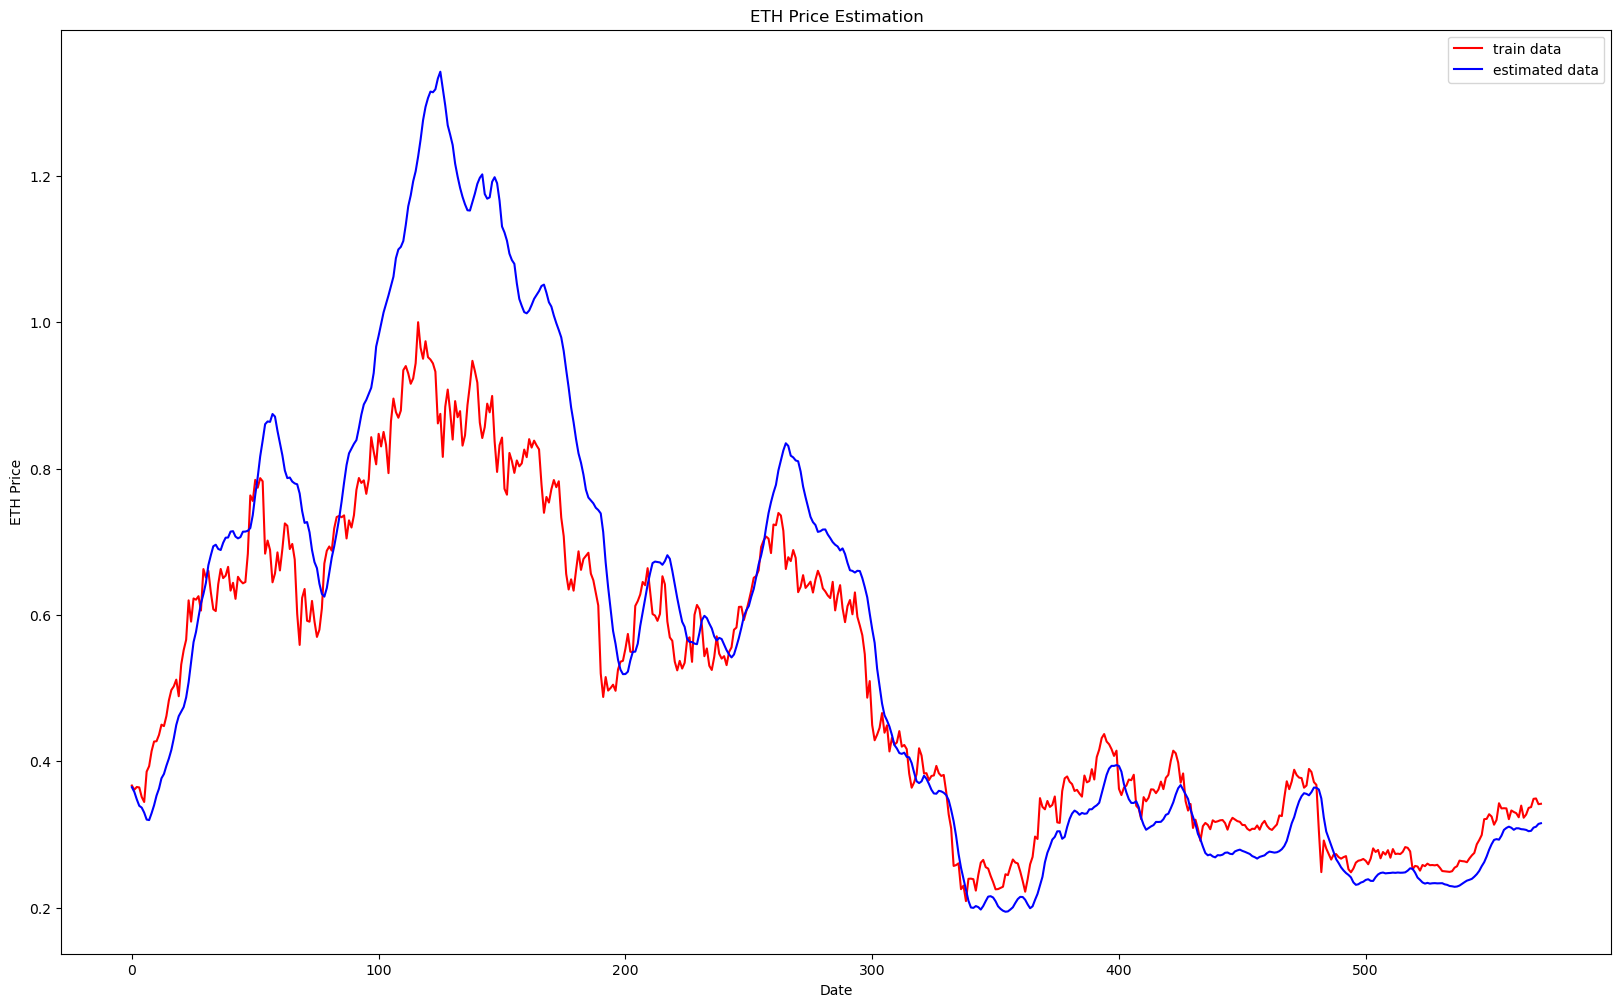

In [31]:
y_pred = model.predict(X_test)
plt.figure(figsize=(20,12))
plt.plot(y_test, color='red', label='train data')
plt.plot(y_pred, color='blue', label='estimated data')
plt.title('ETH Price Estimation')
plt.xlabel('Date')
plt.ylabel('ETH Price')
plt.legend()
plt.show()

In [32]:
last_estimated_price = (df_dns.Close[-1] * y_pred[-1]) / df_y.Close[-1]
last_real_price = df_dns.Close[-1]
a = last_estimated_price - last_real_price
print("2023-02-06 예상 ETH 가격 :", last_estimated_price, 'KRW')
print("2023-02-06 실제 ETH 가격 :", last_real_price, 'KRW')
print("차이 : ", a)

2023-02-06 예상 ETH 가격 : [1880521.8] KRW
2023-02-06 실제 ETH 가격 : 2038984.625 KRW
차이 :  [-158462.88]


### 미국 3대지수를 추가하니 뭔가 더 안맞아 보이는듯..
- 1. 10일치의 데이터 비교 말고 기간을 늘리거나
- 2. 모델링 설계를 다시하거나 해야할 듯